In [81]:
# Run 'source ~/.profile'
import satpy
from satpy import Scene, find_files_and_readers
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyresample import geometry
from pyproj import CRS
from satpy.composites import GenericCompositor
from satpy.writers import to_image
import os
import xarray as xr

from global_land_mask import globe

In [106]:
capture_directory = '/home/cameron/Dokumenter/Data/frohavet'

sys.path.insert(0,'/home/cameron/Projects/')

In [107]:

# ====== Functions =======

def process_capture(nc_file, points_file, name):

    files = [points_file, nc_file]

    print('[INFO] Processing capture ' + str(nc_file))

    scene = Scene(filenames=files, reader='hypso1_l1a_nc', reader_kwargs={'flip': True})
    datasets = scene.available_dataset_names()

    scene.load(datasets)
    #scene.load(['latitude', 'longitude', '80', '40', '15'])


    #write_composites(scene, name)


    #write_nc(resampled_scene, scene.available_dataset_names(), name)
    #write_nc(resampled_scene, datasets, name)

    #exit()



def write_composites(scene, name, gamma=2):

    # Original capture composite
    s = scene
    compositor = GenericCompositor("overview")
    composite = compositor([s['band_80'][:,::3], s['band_40'][:,::3], s['band_15'][:,::3]]) # Red, Green, Blue
    #composite = composite[:,:,::-1] # correct for composite mirroring
    img = to_image(composite[:,:,::-1]) 
    img.invert([False, False, False])
    img.stretch("linear")
    img.gamma([gamma, gamma, gamma])
    img.save('./composites_out/' + name + '.png')



def write_nc(scene, datasets, name):

    scene.save_datasets(writer='cf', 
                        datasets=datasets, 
                        filename = './datasets_out/' + name + '.nc')


In [109]:
# ====== Script =======

# Filter files ending in '-l1a.nc' or '-bin3.points'
l1a_files = [os.path.join(capture_directory, file) for file in os.listdir(capture_directory) if file.endswith('l1a.nc')]
bin3_files = [os.path.join(capture_directory, file) for file in os.listdir(capture_directory) if file.endswith('bin3.points')]

# Match pairs of files based on the first part of their file names
matched_pairs = []
for l1a_file in l1a_files:
    l1a_prefix = l1a_file.rsplit('-', maxsplit=1)[0]
    for bin3_file in bin3_files:
        bin3_prefix = bin3_file.rsplit('-', maxsplit=1)[0]
        if l1a_prefix == bin3_prefix:
            l1a_file_prefix = l1a_prefix.split('/')[-1]
            matched_pairs.append((l1a_file, bin3_file, l1a_file_prefix))
            bin3_files.remove(bin3_file)  # Avoid duplicate matches


for pair in matched_pairs:

    nc_file = pair[0]
    points_file = pair[1]
    name = pair[2]

    #process_capture(nc_file=nc_file, 
    #                points_file=points_file, 
    #                name=name)

In [110]:
matched_pairs

[('/home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-l1a.nc',
  '/home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-bin3.points',
  'frohavet_2023-03-29_1044Z')]

In [154]:
points_file = matched_pairs[0][1]
nc_file = matched_pairs[0][0]
l1a_file_prefix = matched_pairs[0][2]

files = [points_file, nc_file]

print('[INFO] Processing capture ' + str(nc_file))

scene = Scene(filenames=files, reader='hypso1_l1a_nc', reader_kwargs={'flip': True})


[INFO] Processing capture /home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-l1a.nc


In [155]:
datasets = scene.available_dataset_names()

scene.load(datasets)
#scene.load(['latitude', 'longitude', '80', '40', '15'])

In [156]:
scene

In [114]:
spectral_coeffs = [ -5.719788129534360902e-09,
                    1.324037080791479811e-05, 
                    3.751455956374321055e-01,
                    2.264762366937773663e+02]
x_start = 428
x_stop = 1508
image_width = 120

x = np.linspace(x_start, x_stop, image_width)

h1_wl = spectral_coeffs[3] + spectral_coeffs[2]*x + spectral_coeffs[1]*x*x + spectral_coeffs[0]*x*x*x


a = abs(h1_wl-549)
min_index = np.argmin(a)
band_549nm_name = 'band_' + str(min_index)

a = abs(h1_wl-663)
min_index = np.argmin(a)
band_663nm_name = 'band_' + str(min_index)

In [115]:
print(band_549nm_name)
print(scene['band_45'].wavelength) # This does not match?

band_46
547


In [116]:
print(band_663nm_name)
print(scene['band_77'].wavelength) # This does not match?

band_78
658


In [62]:
img_dims = scene['latitude'].shape

land_mask = np.zeros(img_dims, dtype=bool)

lats = scene['latitude'].data
lons = scene['longitude'].data

for x in range(0,img_dims[0]):
    for y in range(0,img_dims[1]):
        lat = lats[x][y]
        lon = lons[x][y]
        land_mask[x][y] = globe.is_land(lat, lon)



In [132]:
cloud_mask = np.zeros(img_dims, dtype=bool)

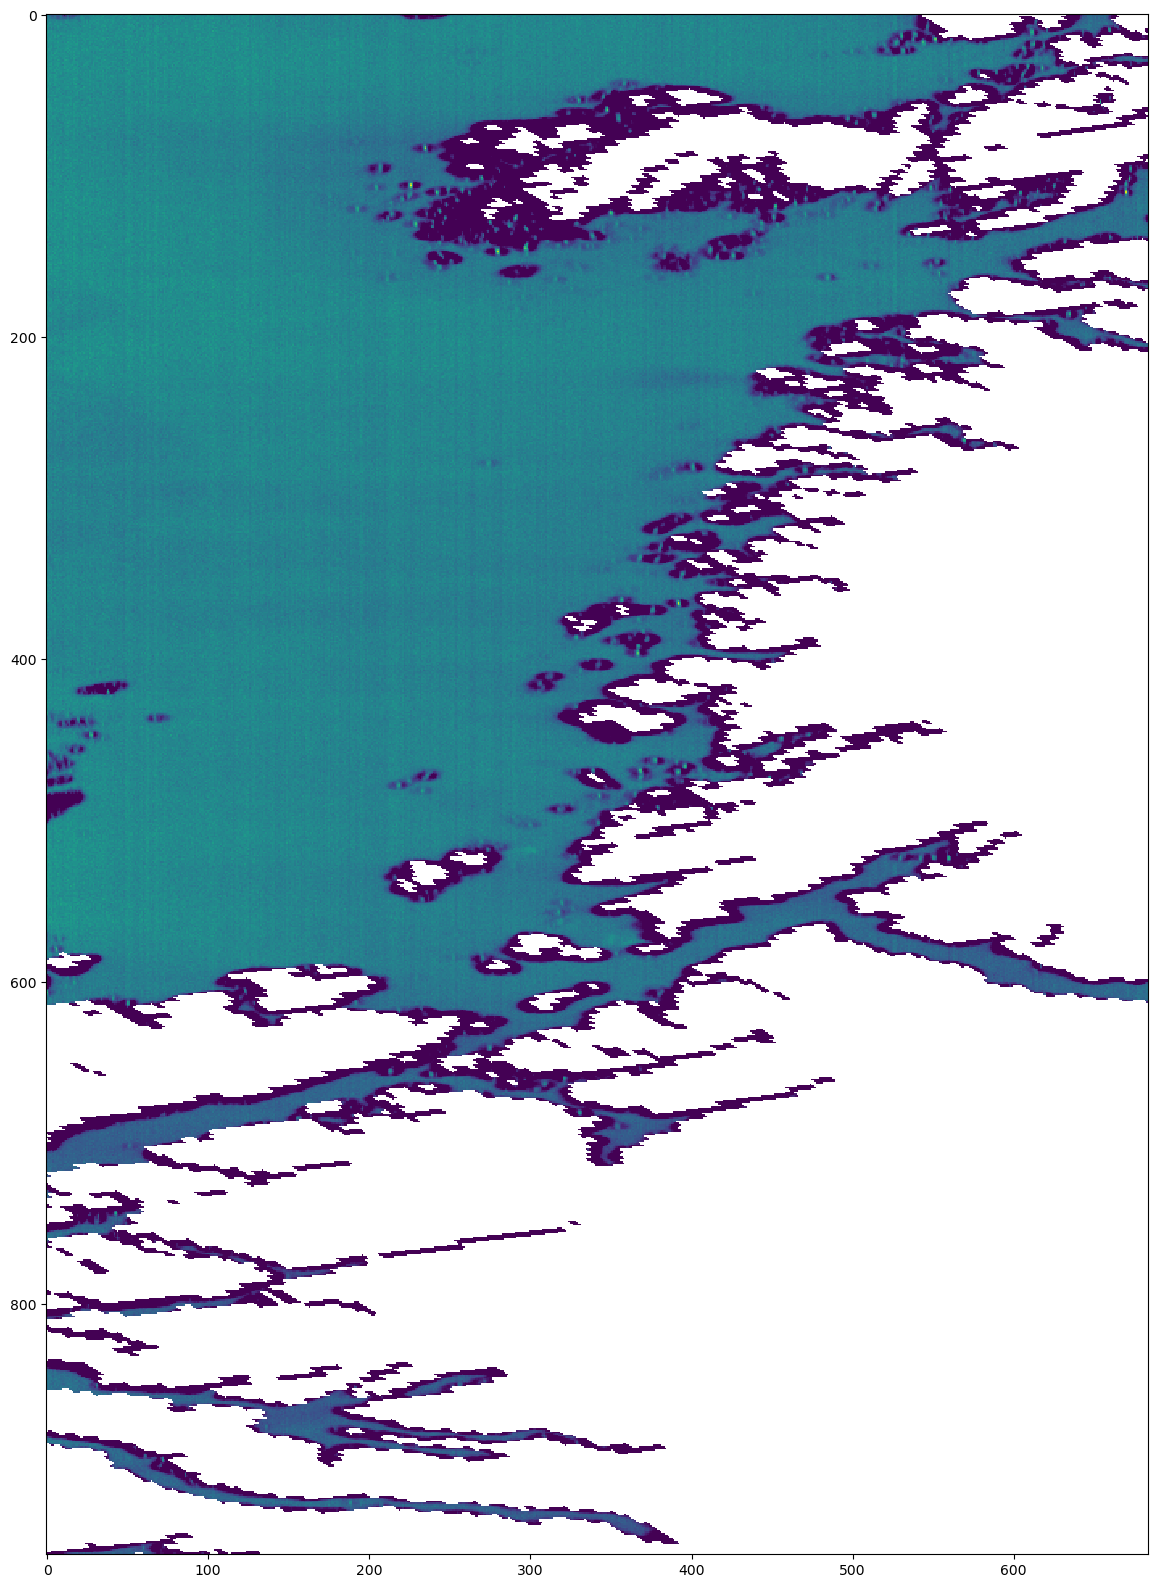

In [118]:
chlor = scene[band_549nm_name] / scene[band_663nm_name]
chlor = chlor.to_numpy()

chlor = np.ma.masked_array(chlor, land_mask, fill_value=np.nan)



chlor = chlor - 0.6*chlor.compressed().max()
#chlor = chlor - 0.88*chlor.compressed().max()
chlor[chlor < 0] = 0

chlor

plt.figure(figsize=(20,20))
plt.imshow(chlor[:,::-1], interpolation='none')
#plt.plot(457,106,'ro') 

# Concentration in units mg m-3

In [128]:
scene['band_40']

<xarray.DataArray (y: 956, x: 684)>
array([[ 75.98103 ,  82.17207 ,  82.97371 , ...,  20.633526,  22.062332,
         22.085396],
       [ 59.416466,  66.25708 ,  77.040855, ...,  20.457756,  21.920713,
         21.446173],
       [ 52.33102 ,  58.933193,  75.77672 , ...,  20.333431,  20.976595,
         20.665377],
       ...,
       [146.99316 , 133.75247 , 121.90833 , ...,  81.48377 ,  74.229164,
         67.61615 ],
       [175.74107 , 176.59239 , 159.82782 , ...,  60.451557,  60.848434,
         58.289486],
       [175.74107 , 177.23323 , 176.13239 , ...,  43.333405,  45.59234 ,
         46.157104]], dtype=float32)
Coordinates:
    crs      object +proj=longlat +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes:
    start_time:           2023-03-29 10:44:00
    capture_config:       {'aoi_x': 428, 'aoi_y': 266, 'background_value': 72...
    end_time:             2023-03-29 10:44:00
    reader:               hypso1_l1a_nc
    area:                 Shape: (956, 684)\nLons: <xarray.DataArray (y: 956,...
    name:                 band_40
    wavelength:           529
    modifiers:            ()
    _satpy_id:            DataID(name='band_40', wavelength=529, modifiers=())
    ancillary_variables:  []

In [172]:
type(scene['band_40'].coords)

xarray.core.coordinates.DataArrayCoordinates

In [179]:
coords = scene['band_40'].coords

scene['chlor_a'] = xr.DataArray(chlor, coords=coords)
scene['chlor_a'].attrs['area'] = scene['band_40'].attrs['area']
scene['chlor_a'].attrs['start_time'] = scene['band_40'].attrs['start_time']
scene['chlor_a'].attrs['end_time'] = scene['band_40'].attrs['end_time']
scene['chlor_a'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['chlor_a'].attrs['ancillary_variables'] = []

scene['land_mask'] = xr.DataArray(land_mask, coords=coords)
scene['land_mask'].attrs['area'] = scene['band_40'].attrs['area']
scene['land_mask'].attrs['start_time'] = scene['band_40'].attrs['start_time']
scene['land_mask'].attrs['end_time'] = scene['band_40'].attrs['end_time']
scene['land_mask'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['land_mask'].attrs['ancillary_variables'] = []

scene['cloud_mask'] = xr.DataArray(cloud_mask, coords=coords)
scene['cloud_mask'].attrs['area'] = scene['band_40'].attrs['area']
scene['cloud_mask'].attrs['start_time'] = scene['band_40'].attrs['start_time']
scene['cloud_mask'].attrs['end_time'] = scene['band_40'].attrs['end_time']
scene['cloud_mask'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['cloud_mask'].attrs['ancillary_variables'] = []

#scene['chlor_a'] = scene['band_40'].copy(deep=True)
#scene['chlor_a'].data = chlor
#scene['chlor_a'].attrs['wavelength'] = None

#scene['land_mask'] = scene['band_40'].copy(deep=True)
#scene['land_mask'].data = land_mask
#scene['land_mask'].attrs['wavelength'] = None

#scene['cloud_mask'] = scene['band_40'].copy(deep=True)
#scene['cloud_mask'].data = cloud_mask
#scene['cloud_mask'].attrs['wavelength'] = None

#scene['land_mask'].attrs['_satpy_id']

In [181]:
write_nc(scene, ['chlor_a', 'land_mask', 'cloud_mask'], l1a_file_prefix+'-chlor_a')

/home/cameron/miniforge3/lib/python3.10/site-packages/satpy/writers/cf_writer.py:274: UserWarning: dtype bool not compatible with CF-1.7.
  grouped_datasets, header_attrs = collect_cf_datasets(list_dataarrays=datasets,  # list of xr.DataArray


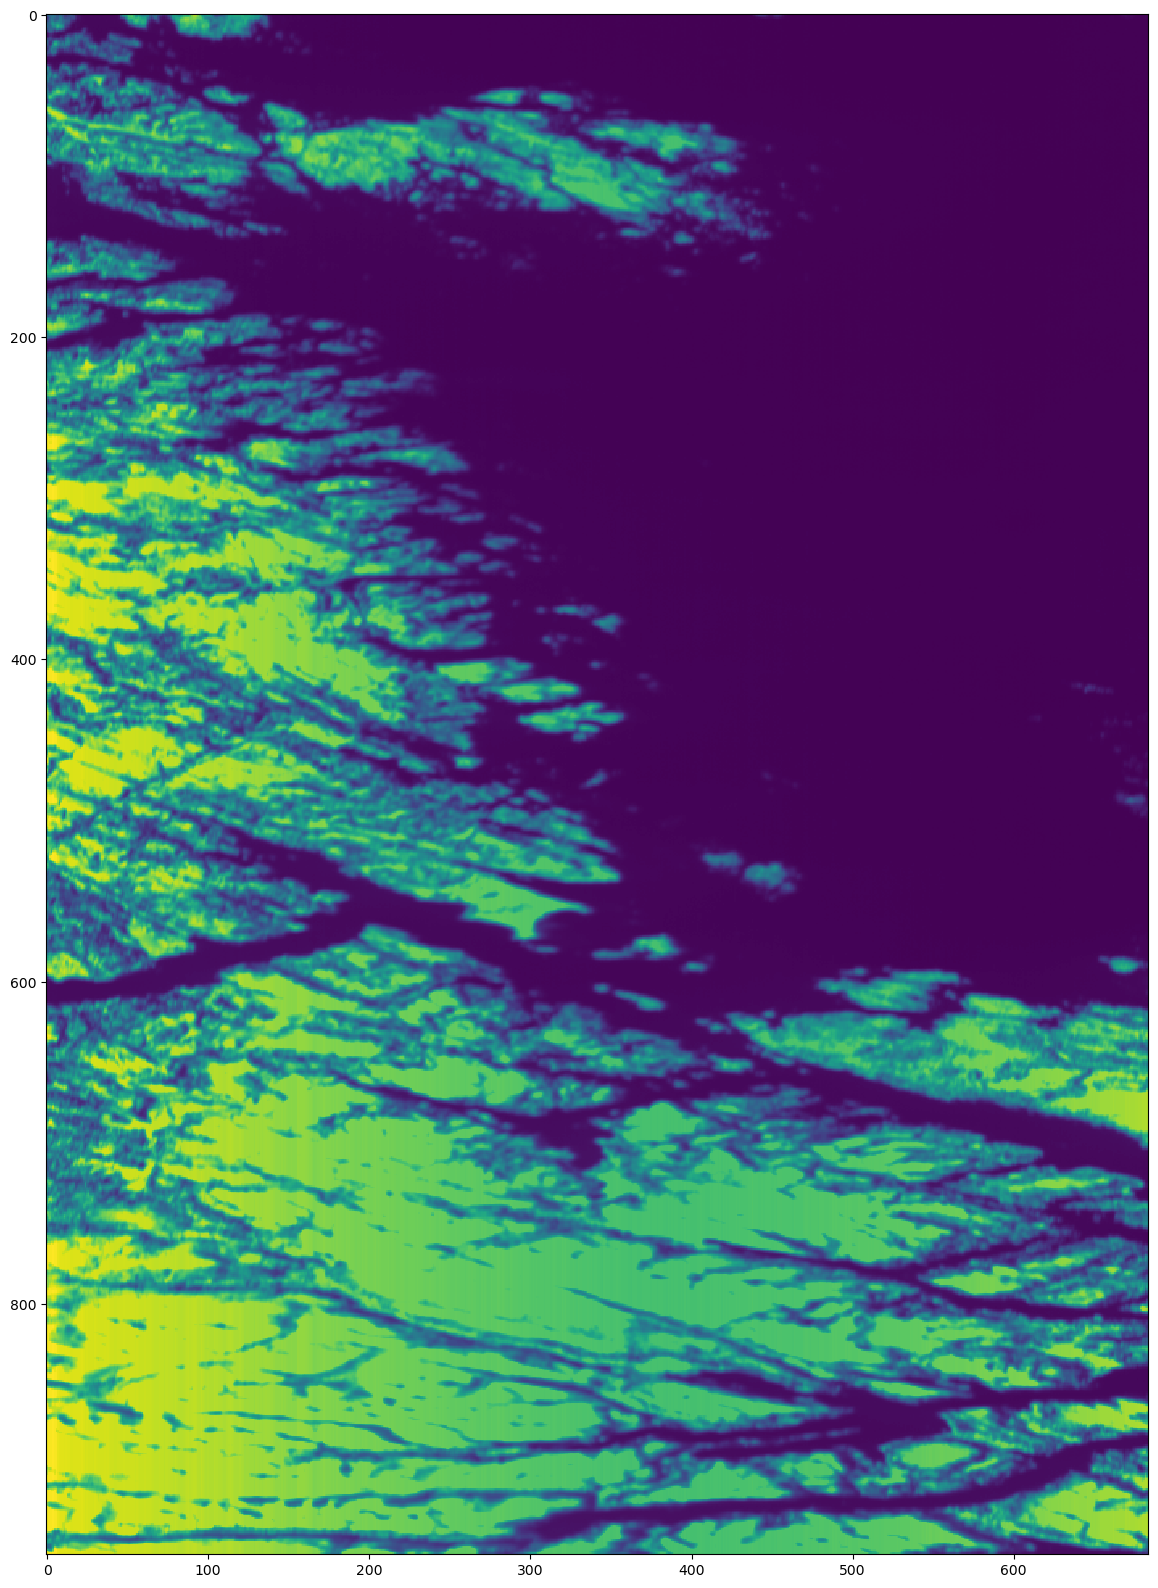

In [75]:
plt.figure(figsize=(20,20))
plt.imshow(scene['band_50'], interpolation='none')

In [32]:
max_index_flat = np.ma.argmax(chlor)
max_index = np.unravel_index(max_index_flat, chlor.shape)

In [33]:
max_index

(106, 457)